## **CIS545 Final Project - Genetic Makeup for Cancer Types**

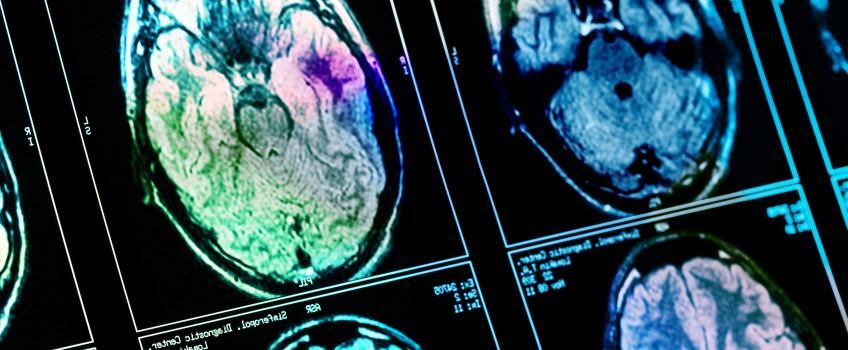

## INTRO: 

Can we group people using large dimensions of mRNA sequences? If so, we can dig deeper to see what similarities are there within each group, which may guide researchers to conduct further studies. This project aims to classify cancer patients based on gene density information, with the ultimate hope for this project to serve as a diagnosic tool for measuring a patient's propensity for cancer.

## **SECTION 1: CLEANING AND WRANGLING DATA**

## 1.1 Downloading

*In this section, we are going to download the csv file into the notebook and read it as a dataframe. We will also import all of the packages we are going to use when cleaning, wrangling, analyzing, and modeling the data.*

We first start by importing all of the necessary packages to be used throughout the project:



In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from random import randint
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

We then read the csv file containing the gene density information for patients with either breast (BRCA) or brain (GBM) cancer:

In [ ]:
data = pd.read_csv('tcga.csv')

In [ ]:
data

,type,A2M,NAT1,NAT2,RP11-986E7.7,AADAC,AAMP,AANAT,AARS,ABAT,ABCA1,ABCA2,ABCA3,ABCB7,ABCF1,ABCA4,ABL1,AOC1,ABL2,ABO,ABR,ACAA1,ACACA,ACACB,ACADL,ACADM,ACADS,ACADSB,ACADVL,ACAT1,ACAT2,ASIC2,ASIC1,ACHE,ACLY,ACO1,ACR,ACO2,ACOX1,ACP1,...,C17orf96,PRICKLE4.1,LINC00426,LINC00092,DNMBP-AS1,DCTN1-AS1,RAMP2-AS1,TPT1-AS1,RP11-474D1.3,C5orf52,C2CD4D,ZFHX4-AS1,XXbac-B476C20.17,RP11-789C17.3,LINC00704,PCED1B-AS1,RP11-834C11.6,RP11-834C11.7,CTC-308K20.1,RP5-1068E13.7,ARHGEF33,AL121656.5,CTD-2547E10.2.1,MEF2B,CMC4,LINC00894,BCDIN3D-AS1,LINC00173,ANKRD66,ULK4P1,WASH2P.2,FRG2C,ZNF605,RP11-55K22.5,RASAL2-AS1,LINC00882,FTX,TICAM2.1,SLC25A5-AS1,otype
0,BRCA,14979.8342,1637.8712,1.5426,51999.6143,0.7713,2356.3440,0.3857,2048.2067,2242.5762,382.5685,1807.5588,793.2896,350.5592,1376.7836,15.0405,1942.9233,33.5519,1253.3745,19.2827,1621.6737,1130.7366,1732.3563,227.9213,0.0000,1241.0336,286.1550,2868.8777,2510.9834,638.2568,559.8920,2.6996,139.2210,32.3949,6616.2746,789.0474,3.0852,2719.6722,1388.0987,1880.8330,...,73.2742,1901.8666,27.7671,5.0135,21.6390,0.7713,90.6286,84.8438,1.5426,0.0000,44.6433,3.8565,0.3857,0.0000,0.7713,73.2742,3.0852,6.5561,3.4709,20.4396,10.4126,0.0000,401.9977,32.4219,221.2110,28.9240,15.6807,24.2962,0.0000,0.7713,405.6421,0.0000,465.8696,3.8565,22.8808,2.6996,24.2962,25.5418,21.5966,1
1,BRCA,6155.8647,11795.9872,40.7525,25044.0653,3.0002,1616.6010,0.0000,2117.1323,1742.1089,624.5390,1131.0707,6015.3760,559.2850,1930.8707,34.7522,1575.5985,3.7502,1715.1072,93.7559,1650.8532,1579.5987,3616.9761,229.5143,3.7502,878.3049,170.7607,4484.2803,5051.1682,2106.1316,531.7282,0.2500,239.2650,4.2503,6050.1281,1135.8210,3.7502,2122.6977,1870.2544,1306.0816,...,82.2551,1494.6509,1.5001,0.7500,6.9154,3.7502,41.5026,57.2536,0.0000,0.0000,19.7362,1.7501,0.0000,1.2501,0.0000,1.5001,0.0000,3.2502,5.0003,28.4843,4.0003,0.2500,444.1053,9.8381,186.7217,24.0015,25.4666,90.5057,0.0000,0.2500,214.9209,0.2500,784.5490,1.0001,13.0583,6.0004,22.2514,161.4351,15.2510,1
2,BRCA,5833.7414,2336.4723,21.7313,43929.7356,0.0000,3180.0072,0.3622,2911.9884,4726.5484,460.3405,1709.8877,4351.6842,291.5610,2278.1601,3.9841,1579.5002,212.9663,906.5556,6.5194,2432.8142,1465.0489,4145.9616,72.4375,3.2597,445.4908,518.6527,2991.6697,1655.5487,689.6052,486.3274,10.1413,227.0916,12.3144,7868.8881,575.5161,2.5353,2740.8801,1948.2977,993.4806,...,244.1145,2811.3075,0.3622,0.3622,4.5527,1.8109,66.6425,54.3281,0.0000,0.0000,34.9076,2.1731,0.0000,0.0000,0.3622,1.8109,0.0000,3.2597,5.7950,11.5900,2.1731,0.0000,284.8135,41.6624,289.6088,13.0388,25.2372,1.4488,0.0000,0.3622,196.7946,0.0000,266.5701,0.3622,6.8816,0.3622,11.9522,34.8135,23.5422,1
3,BRCA,11373.9641,470.1430,3.0838,1539.9495,0.0000,2477.9927,0.2803,8047.3787,500.1402,828.4272,1013.7370,2714.6061,792.5428,3331.3709,10.0925,1567.7040,3.6445,600.5046,0.5607,1319.8766,765.9097,2296.6078,341.4634,0.0000,1155.8733,364.4519,5333.8940,3122.7782,1619.0076,722.6128,0.0000,13.4567,20.4654,3622.0914,1272.7782,0.8410,3456.9947,1145.9125,1890.3841,...,149.9860,2543.4819,6.4480,0.2803,0.3168,0.0000,81.3008,120.2691,0.0000,0.0000,6.4480,8.4104,0.2803,0.0000,0.2803,27.1937,1.4017,7.2890,3.3642,40.8803,5.0463,0.2803,305.3967,3.3193,373.6698,20.7457,23.5548,35.0435,0.0000,1.6821,323.0053,0.0000,491.4494,0.0000,10.6756,1.6821,26.9134,96.2321,38.9683,1
4,BRCA,7400.3687,80.6340,2.4121,3627.4983,1.0338,4301.1716,1.0338,2834.2522,357.3398,437.6292,3216.4025,1689.8691,301.1716,2461.7505,11.7161,2601.3094,177.1192,906.6161,5.5134,2308.7526,1330.4618,3122.3294,487.2502,0.3446,1141.2819,380.7719,680.5651,2986.5541,572.7085,598.6733,7.2364,216.7471,101.6540,6064.7829,750.1723,6.2026,2124.8553,2586.6023,2570.9855,...,243.2805,2101.1337,30.6685,5.5134,5.8305,0.6892,15.8511,162.9910,0.0000,0.0000,55.9717,4.4797,0.0000,0.0000,0.0000,54.1006,1.0338,13.7836,2.7567,25.4997,7.5810,0.0000,252.3432,54.8139,137.3742,21.3646,17.7636,4.8243,0.0000,1.7229,1315.3377,0.0000,514.8174,0.0000,13.2012,0.6892,15.1620,32.8015,11.7161,1
...,...,...,...,...,...,...,...

## 1.2 Cleaning

*In this section, we will clean the data we are working with. The process of cleaning the data involves searching and correcting invalid records in the dataset. By dropping rows with NA values and columns with all entries equal to 0, we will have a cleaner, smaller dataset to work with and run analytical tools more efficiently.*

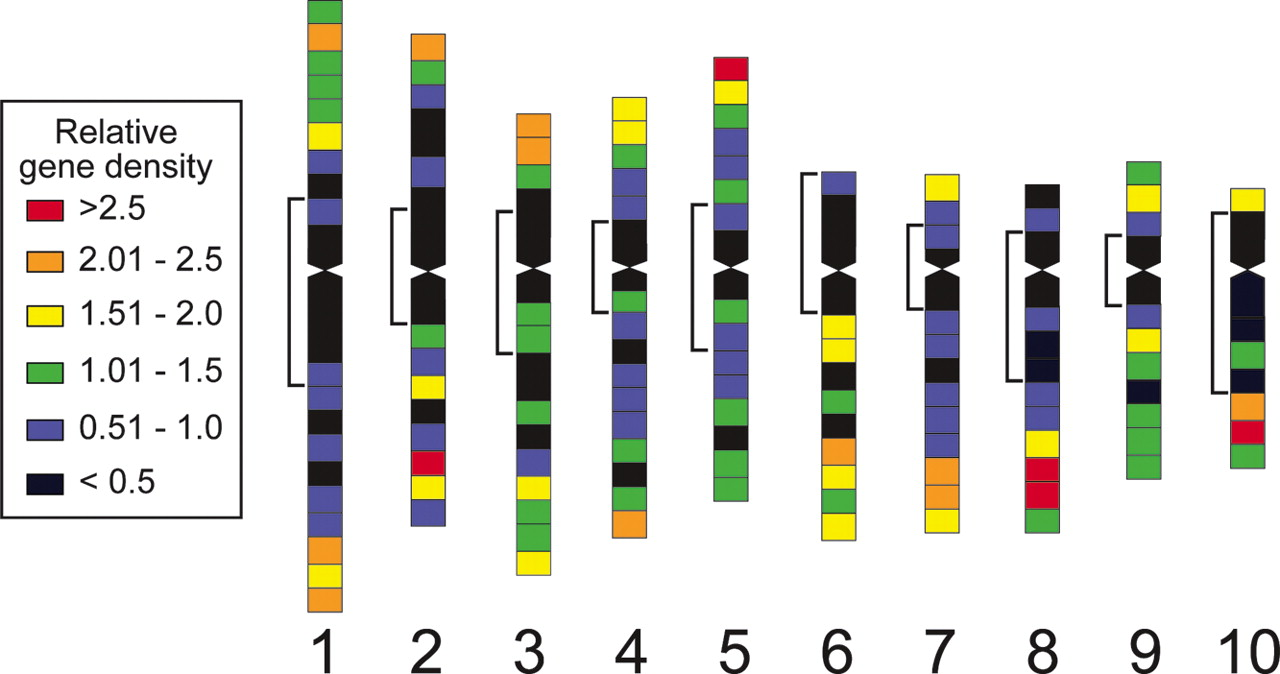

In [ ]:
data.dropna(inplace=True)
data = data.loc[:, (data != 0).any(axis=0)]

It is usally easier to work with numeric variables than with strings. Therefore, we are going to encode the cancer type column to have a value of 0 is the patient has breast cancer or a value of 1 if the patient has brain cancer.

In [ ]:
data['type'][data.type == 'BRCA'] = 0
data['type'][data.type == 'GBM'] = 1
data['type'] = data['type'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/pyt

Let's graph the density distribution of randomly selected genes to see whether the data needs to be transformed. Nine different genes will be selected from our pool of thousands in the dataframe, and the density across all patients will be plotted in a histogram to evaluate the shape of the distribution.

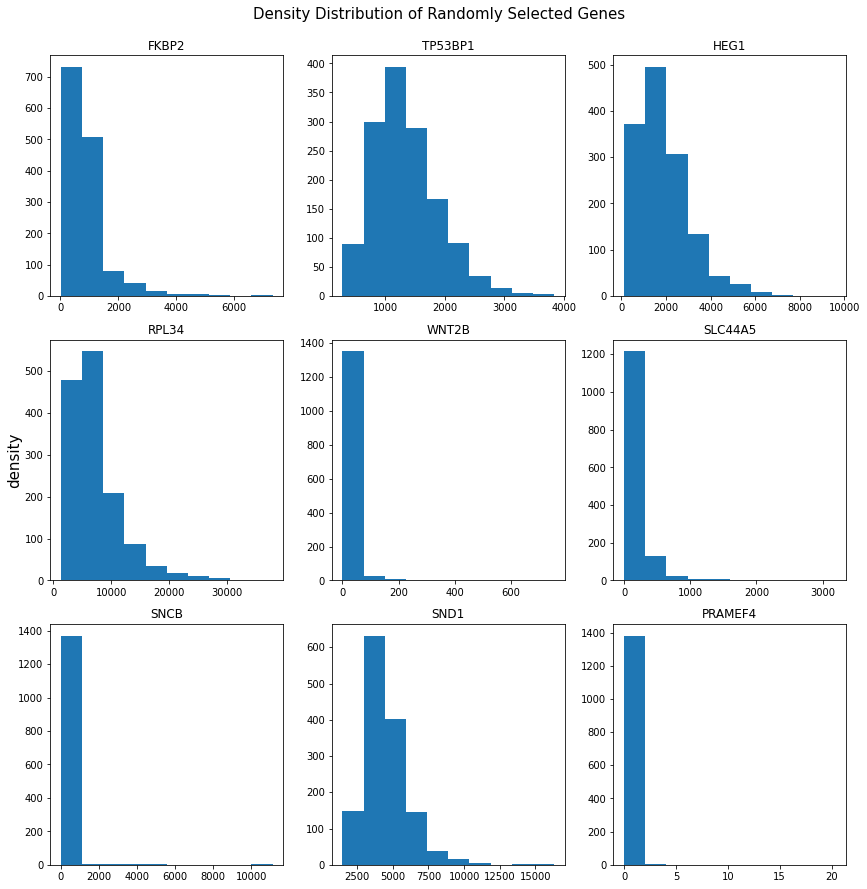

In [ ]:
import random

randomlist = random.sample(range(1, len(data.columns)), 9)
randomlist.sort()

fig, axs = plt.subplots(3, 3, figsize=(12,12))
for y in range(0,3):
  for x in range(0,3):
    axs[x,y].hist(data.iloc[:,randomlist[x+3*y]])
    axs[x,y].set_title(data.columns[randomlist[x+3*y]])

fig.text(0, 0.5, 'density', va='center', rotation='vertical', fontsize=15)
fig.suptitle('Density Distribution of Randomly Selected Genes', y=1.025, fontsize=15)
plt.tight_layout()

Since the distributions are skewed to the right, the data must be transformed using the log transform. However, to avoid undefined values in the data, all values will be shifted by 1.

In [ ]:
for ii in range(1,len(data.columns)):
  data[data.columns[ii]] = data[data.columns[ii]].apply(lambda x: np.log(x+1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


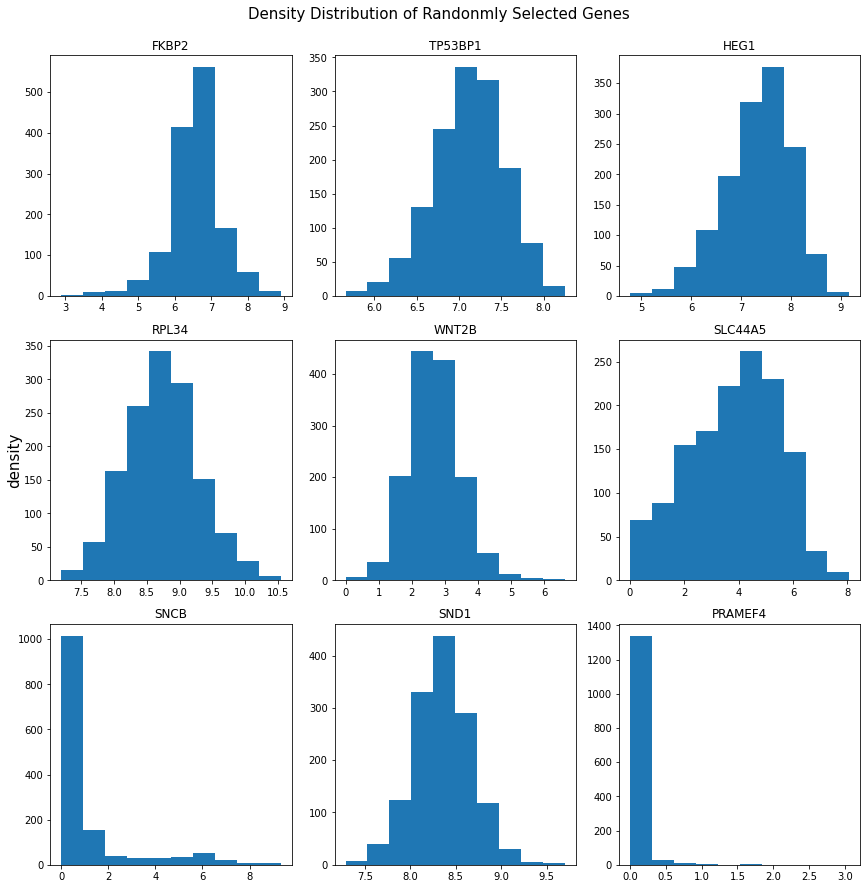

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(12,12))
for x in range(0,3):
  for y in range(0,3):
    axs[x,y].hist(data.iloc[:,randomlist[x+3*y]])
    axs[x,y].set_title(data.columns[randomlist[x+3*y]])

fig.text(0, 0.5, 'density', va='center', rotation='vertical', fontsize=15)
fig.suptitle('Density Distribution of Randonmly Selected Genes', y=1.025, fontsize=15)
plt.tight_layout()

Done! The data looks more symmetrical, as it looks more similar to a normal distribution. Now that the data is cleaned and transformed, we can start to visualize it using different packages such as seaborn or matplotlib. The initial heatmap demonstrates that the data requires modeling to make sense of it. 


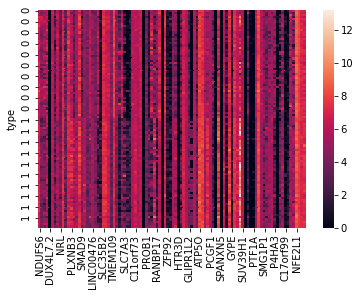

In [ ]:
np.random.seed(2019)

heat_df = data.sample(n=100,axis='columns')
heat_df['type'] = data['type']

BRCA_type_df = heat_df[heat_df['type'] == 0]
GBM_type_df = heat_df[heat_df['type'] == 1]

GBM_type_df = GBM_type_df.sample(n = 50)
BRCA_type_df = BRCA_type_df.sample(n = 50)

heat_df = BRCA_type_df.append(GBM_type_df)

heat_df = heat_df.set_index('type')

heat_df

sns.heatmap(heat_df)

## **SECTION 2: MODELING AND ANALYSIS**


## 2.1 PCA Reduction

We first start with a PCA to reduce the dimensionality of our data since we have a hefty number of columns present. We first try to understand the association between the number of components and the explained variance. 

In [ ]:
label = data['type']
features = data.drop(columns=['type'])

In [ ]:
X = StandardScaler().fit_transform(features)

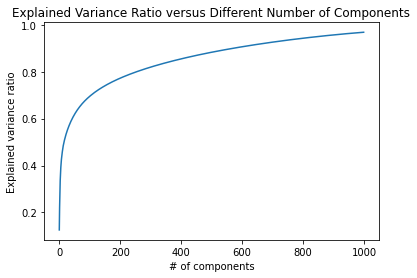

In [ ]:
pca = PCA(n_components = 1000)
X_pca = pca.fit_transform(X)
np.set_printoptions(suppress=True)
pca.explained_variance_ratio_

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks()
plt.xlabel("# of components")
plt.ylabel("Explained variance ratio")
plt.title("Explained Variance Ratio versus Different Number of Components")
plt.show()

We observe that 95% of our variance can be captured with 851 componenets and run our PCA using n = 851.

In [ ]:
[x_train,x_test,y_train,y_test] = train_test_split(features, label, test_size = .2)

In [ ]:
pca = PCA(n_components=851)
pca.fit(x_train)
X2_train = pca.transform(x_train)

## 2.2 Cluster Analysis

We now proceed to perform a k-means cluster analysis using the PCA transformed data. This will let us see the patients that correspond to one type of cancer versus the other. Therefore, the number of clusters needed is 2, since we are analyzing to find two different cancer types.

In [ ]:
def error(x,c):
  err = np.linalg.norm(x - c)
  return err

def get_nearest(c_list, x):
  nearest = -1
  nearest_error = np.infty
  for i, v in enumerate(c_list):
    if error(x, v) < nearest_error:
      nearest_error = error(x, v)
      nearest = i
  return nearest

In [ ]:
def kmeans_pca(X, k, show):
  centroids = np.zeros((k,851))
  cluster_assignments = [0 for i in range(len(X))]
  for i in range(0, k):
    centroids[i] = X[randint(0, X.shape[0])]

  if show:
    print('Initialized centroids to: ')
    print(centroids)

  iteration = 1
  changed = True
  while changed:
    if show:
      print ('Iteration %d'%iteration)
      iteration = iteration + 1

    changed = False
    for i,x in enumerate(X):
      nearest = get_nearest(centroids, x)
      if nearest != cluster_assignments[i]:
        changed = True
      cluster_assignments[i] = nearest

    if changed:
      for i in range(len(centroids)):
        points = [j for j,v in enumerate(cluster_assignments) if v == i]
        if show:
          print ('Cluster %d'%i)
        X_subset = np.array([[X[i,0],X[i,1]] for i in points])

        if len(X_subset):
          centroids[i][0] = np.sum(X_subset[:, 0]) / len(points)
          centroids[i][1] = np.sum(X_subset[:, 1]) / len(points)
          print (centroids[i])
  return (centroids, np.array(cluster_assignments))

In [ ]:
k = 2
centroids, assignments = kmeans_pca(X2_train, k, True)
assignments

Initialized centroids to: 
[[  1.69683155 -24.58581357  76.40146827 ...  -0.20823857  -0.35797917
    0.39251829]
 [-14.34826396  31.61924811  -2.43736398 ...  -1.76230975  -0.86281569
   -1.75485518]]
Iteration 1
Cluster 0
[  6.66054072 -21.87162457  76.40146827 -40.17924947  13.82113957
   6.8792982   10.01576735   0.7254688  -17.07547184   5.8146189
   0.48685112  -3.65869086  -0.01455459  -2.2949172    8.45110353
  21.33740004  15.79445007  -2.07198012  -7.91849219  -9.57995481
  10.45547119  -8.19619838   0.48390933 -14.48854997   0.44061152
  -0.50517432 -10.29383969   7.24299758   1.71601218   4.86658719
  -6.07673168  -0.41720998  -8.83574353   1.15493111  -3.21242809
   6.56146689  -1.52476809  -5.31741887   1.85712677   7.45302617
  -5.67247613  10.42165997  -5.07535338  -9.43822053  15.20264764
  -2.6964725   -6.39520982   4.86830886  -2.20884217  -1.96538173
   7.16835477 -13.28667122   8.69351842  -0.95754069   1.1366464
  -1.91008613   1.97693132  -2.42705288   6.26134586

array([1, 1, 1, ..., 1, 1, 1])

We plot the results of the clustering analysis on the PCA-reduced data and observe that the clusers decently aggregate the data but that there is significant overlap between both clusters. 

Text(0.5, 0, 'PC1')

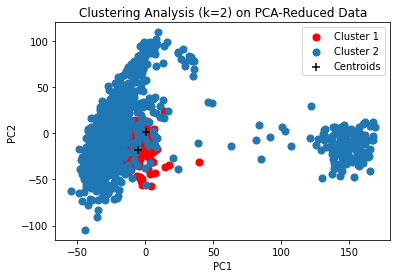

In [ ]:
clust0 = np.array([x for i, x in enumerate(X2_train) if assignments[i] == 0])
clust1 = np.array([x for i, x in enumerate(X2_train) if assignments[i] == 1])

plt.scatter(clust0[:,0], clust0[:,1], c='red', s=50, label='Cluster 1')
plt.scatter(clust1[:,0], clust1[:,1], s=50, label='Cluster 2')
plt.scatter(centroids[:,0], centroids[:,1], c='black',marker='+', s=50, label='Centroids')
plt.title('Clustering Analysis (k=2) on PCA-Reduced Data')
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')

In response to the PCA K-means clustering analysis, we proceed to perform a t-SNE reduction and a subsequent k-means analysis to see which dimensionality reduction technique works best for this data. We must choose three components for t-SNE reduction due to the limitations of the algorithm. 

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=3).fit_transform(x_train)

In [ ]:
def kmeans_sne(X, k, show):
  centroids = np.zeros((k,3))
  cluster_assignments = [0 for i in range(len(X))]
  for i in range(0, k):
    centroids[i] = X[randint(0, X.shape[0])]

  if show:
    print('Initialized centroids to: ')
    print(centroids)

  iteration = 1
  changed = True
  while changed:
    if show:
      print ('Iteration %d'%iteration)
      iteration = iteration + 1

    changed = False
    for i,x in enumerate(X):
      nearest = get_nearest(centroids, x)
      if nearest != cluster_assignments[i]:
        changed = True
      cluster_assignments[i] = nearest

    if changed:
      for i in range(len(centroids)):
        points = [j for j,v in enumerate(cluster_assignments) if v == i]
        if show:
          print ('Cluster %d'%i)
        X_subset = np.array([[X[i,0],X[i,1]] for i in points])

        if len(X_subset):
          centroids[i][0] = np.sum(X_subset[:, 0]) / len(points)
          centroids[i][1] = np.sum(X_subset[:, 1]) / len(points)
          print (centroids[i])
  return (centroids, np.array(cluster_assignments))

In [ ]:
centroids, assignments = kmeans_sne(X_embedded, k, True)
assignments

Initialized centroids to: 
[[-15.61319447  39.2686882   44.98445129]
 [-17.1538353   49.90807724   3.20667768]]
Iteration 1
Cluster 0
[-1.94558951 -5.43202374 44.98445129]
Cluster 1
[1.23750701 4.51427799 3.20667768]
Iteration 2
Cluster 0
[-8.41687061 -7.41743488 44.98445129]
Cluster 1
[2.58615247 3.46084319 3.20667768]
Iteration 3
Cluster 0
[-15.09611788 -10.51321564  44.98445129]
Cluster 1
[4.7457241  4.52961036 3.20667768]
Iteration 4
Cluster 0
[-23.10650297 -17.99396946  44.98445129]
Cluster 1
[7.61348238 7.15794213 3.20667768]
Iteration 5
Cluster 0
[-30.38813984 -22.64250112  44.98445129]
Cluster 1
[10.35066575  8.95860995  3.20667768]
Iteration 6
Cluster 0
[-32.78261021 -23.78846261  44.98445129]
Cluster 1
[11.20649067  9.38276197  3.20667768]
Iteration 7
Cluster 0
[-33.43534736 -23.9172337   44.98445129]
Cluster 1
[11.3725046   9.38607436  3.20667768]
Iteration 8
Cluster 0
[-33.5972593  -23.91612452  44.98445129]
Cluster 1
[11.3727491   9.34572305  3.20667768]
Iteration 9
Cluste

array([0, 1, 1, ..., 1, 1, 1])

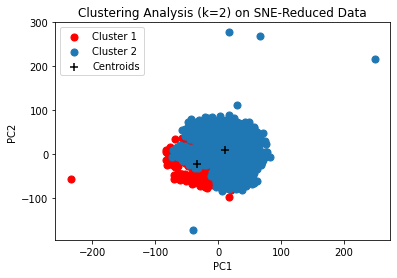

In [ ]:
clust0 = np.array([x for i, x in enumerate(X_embedded) if assignments[i] == 0])
clust1 = np.array([x for i, x in enumerate(X_embedded) if assignments[i] == 1])

plt.scatter(clust0[:,0], clust0[:,1], c='red', s=50, label='Cluster 1')
plt.scatter(clust1[:,0], clust1[:,1], s=50, label='Cluster 2')
plt.scatter(centroids[:,0], centroids[:,1], c='black',marker='+', s=50, label='Centroids')
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.title('Clustering Analysis (k=2) on SNE-Reduced Data')
plt.legend()

After plotting our results from the clustering analysis, we observe that this does a better job at forming homogenous clusters and that the cluster centroids are more distinct than our PCA analysis. However, the PCA reduction method lets us use more components, which is better because the 851 components are able to explain over 80% more of the variance compared to the 3 components used for t-SNE.

In [ ]:
km = KMeans(2, 'random', n_init=1, max_iter=300, random_state=0)
km.fit(X2_train)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=2,
       n_init=1, n_jobs=None, precompute_distances='auto', random_state=0,
       tol=0.0001, verbose=0)

In [ ]:
km.cluster_centers_

array([[145.13896146, -12.90602849, -11.51351793, ...,   0.00096813,
          0.00202281,   0.00197506],
       [-20.41482312,   1.81532434,   1.61945786, ...,  -0.00013617,
         -0.00028452,  -0.00027781]])

## 2.3 Putting it Together

We now build another heatmap to observe any effects of PCA. We see that this heatmap displays a distinction between cancer type 0 and 1, which demonstrates that our PCA analysis is moving this project in the right direction. 

In [ ]:
pc1_gene = pca.components_[0]
pc2_gene = pca.components_[1]
gene_names = data.columns[1:,]

In [ ]:
df_pca1 = pd.DataFrame({'Gene':gene_names,'PC1':pc1_gene}).sort_values(by=['PC1'],ascending=False)[0:50]
df_pca2 = pd.DataFrame({'Gene':gene_names,'PC2':pc2_gene}).sort_values(by=['PC2'],ascending=False)[0:50]
df_pca1.head()

,Gene,PC1
1776,GFAP,0.059853
3589,PMP2,0.051973
2983,MT3,0.048031
258,AQP4,0.046971
3907,PTPRZ1,0.045842


In [ ]:
df_pca2.head()

,Gene,PC2
83,ADH1B,0.057504
6201,ADIPOQ,0.056183
2667,LEP,0.048037
17585,TUSC5,0.047834
1506,FABP4,0.047451


In [ ]:
GBM_type_df = data[data['type'] == 1].sample(n = 50)
BRCA_type_df = data[data['type'] == 0].sample(n = 50)

In [ ]:
df_concat = BRCA_type_df.append(GBM_type_df)

In [ ]:
topgene_list = list(set(list(df_pca1['Gene']) + list(df_pca2['Gene']))) + ['type']

In [ ]:
df_concat = df_concat[topgene_list]
df_concat = df_concat.set_index('type')

After gathering our findings and getting the top 50 loading genes corresponding to each type of cancer, we can draw a second heatmap that better shows the stratification of cancer types according to the top loading genes.

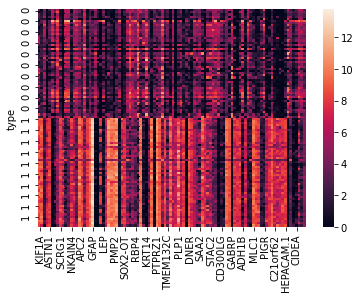

In [ ]:
sns.heatmap(df_concat)

## 2.4 Logistic Regression

We now perform a logistic regression since we have discrete data. The logistic regression model fits best as a model for our situation because we have a binary outcome: BRCA or GBM cancer.

In [ ]:
clf = LogisticRegression(max_iter=10000)
clf.fit(x_train,y_train)
prediction = clf.predict(x_test)
accuracy = metrics.accuracy_score(prediction,y_test)
print("Accuracy: %.1f%%"% (accuracy*100))

Accuracy: 100.0%


Our logistic regression performs incredibly well and achieves an accuracy of 100%. This is reassuring that the logistic model created is effective at predicting the cancer type using the genetic transcripion found in the patient. Now, we will proceed to run another logistic regression using a built machine learning pipeline to scale and reduce the training data.

In [ ]:
scl = StandardScaler()

pca = PCA()

clf = LogisticRegression(max_iter=10000, penalty='l2')
pipe = Pipeline(steps=[('Scale',scl),('PCA',pca),('LogReg',clf)])
pipe.fit(x_train,y_train)
prediction = pipe.predict(x_test)

accuracy = metrics.accuracy_score(prediction,y_test)
print("Accuracy: %.1f%%"% (accuracy*100))

Accuracy: 100.0%


Once, again our logistic regression performed incredibly well and achieves an accuracy of 100%. This is reassuring, and indicates that the logistic model using the reduced and scaled data is just as good at predicting cancer types from genetic transcription.

## 2.5 Random Forest

We also build a random forest to see if it performs as well as our logistic regression. We first tune the hyperparameters of the classifier using a GridSearch object:

In [ ]:
depth = [10, 20, 30]
nEstimator = 140
parameters = { 
        "n_estimators": [nEstimator],
        "max_depth": depth
        }
GS_object = GridSearchCV(estimator = RandomForestRegressor(n_estimators=nEstimator), param_grid=parameters)
GS_object.fit(x_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=140, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [ ]:
crf = RandomForestRegressor(max_depth=20, n_estimators=nEstimator)
crf.fit(x_train,y_train)
y_pred = crf.predict(x_test)
mean_sqr_err = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", mean_sqr_err)

Root Mean Squared Error: 0.02088642723063773


We achieve a low RMSE, demonstrating that this model too is performing well.

## Conclusion:

Our project built models to classify cancer patients based on gene density. Our models did an excellent job at predicting the cancer type from mRNA transcription data. This project has significant potential to revolutionize how we approach cancer diagnositics, especially with the advent of genetic sequencing that allows us to capture and harness such data. 

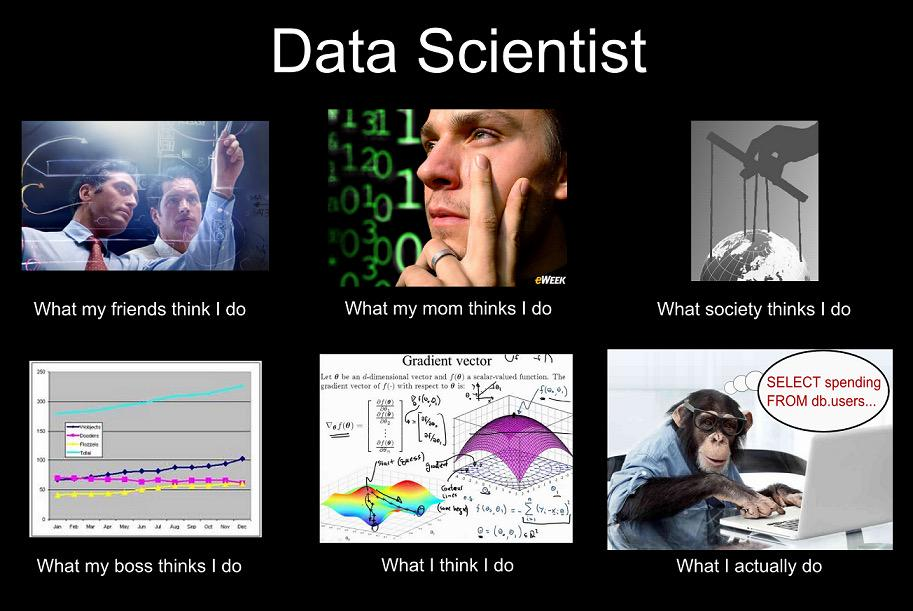